# Optimization projec: clustering

In [1]:
import numpy as np
from numpy import random
import pandas as pd
from sklearn.neighbors import DistanceMetric
import functools
import operator
import matplotlib.pyplot as plt

__Given that we don't have the proper datafiles to run the code, we will use synthetic ones to still do the work, and
as soon as we have the real files we will just substitute them.__

In [18]:
#Simulate dataframe
def simulate_data(N):
    X1 = np.random.uniform(low=0, high=25, size=(N,))
    X2 = np.random.uniform(low=5, high=30, size=(N))
    return X1, X2

# Minimum Spanning Tree Clustering


## naive approach: compute all distances:

In [3]:
def compute_dist(X1, X2):
    result = []
    for i in range(len(X1)):
        for j in range(i+1,len(X2)):
            d = np.linalg.norm(np.array([x1[i], x2[i]]) - np.array([x1[j], x2[j]]))
            result.append([i, j, d])

    ordered_result = sorted(result, key=lambda t: t[::-1])
    return ordered_result

## MST

To find the minimum spanning tree it makes sense to differentiate the following cases:

    case 1: None of them are in a cluster:
    case 2: Only one of them is already in a cluster:
    case 3: Both of them are already in a cluster:
        --> 3a: Both of them are in the same cluster: do nothing
        --> 3b: They are in different clusters: merge the 2 corresponding clusters


In [4]:
def MST_clustering(K, ordered_result):
    cluster_dict = {}
    cluster_count = 1
    edge_count = 0
    visited = []
    
    
    for ite in ordered_result:
        # termination condition: if we are at K clusters, we just add the unvisited vertices as lone clusters
        if edge_count == 200 - K:
            for i in range(2):
                if ite[i] not in visited:
                    cluster_dict[cluster_count] = [ite[i]]
                    visited.append(ite[i])
                    cluster_count += 1
        # case 1:
        elif ite[0] not in visited and ite[1] not in visited:
            cluster_dict[cluster_count] = ite[:2]
            [visited.append(n) for n in ite[:2]]
            cluster_count += 1
            edge_count += 1
        # case 2:
        elif ite[0] in visited and ite[1] not in visited:
            for key, v in cluster_dict.items():
                if ite[0] in v:
                    cluster_dict[key].append(ite[1])
                    visited.append(ite[1])
                    edge_count += 1
        # case 2b: The other one:
        elif ite[1] in visited and ite[0] not in visited:
            for key, v in cluster_dict.items():
                if ite[1] in v:
                    cluster_dict[key].append(ite[0])
                    visited.append(ite[0])
                    edge_count += 1
        # case 3:
        elif ite[0] in visited and ite[1] in visited:
            for num in range(2):
                for key, v in cluster_dict.items():
                    if ite[num] in v:
                        # case 3: They are in different clusters: merge the 2 corresponding clusters
                        if ite[1-num] not in v:
                            if num == 0:
                                #cluster_dict[key].append(ite[num])
                                store_cluster = cluster_dict[key].copy()
                                cluster_dict[key] = []
                            elif num == 1:
                                [cluster_dict[key].append(n) for n in store_cluster]
                                edge_count += 1
                                
    # drop the keys where values were added to another key due to merging two clusters
    cluster_dict = {k: v for k, v in cluster_dict.items() if v != []}
    return cluster_dict

In [5]:
def get_df(cluster_dict):
    ind_list = []
    clust_list = []

    for k, v in cluster_dict.items():
        [clust_list.append(k) for i in v]
        [ind_list.append(val) for val in v]

    df_s = pd.DataFrame()
    df_s['index'] = ind_list
    df_s['cluster'] = clust_list
    
    df_s = df_s.sort_values('index').set_index('index')
    
    df_s['x1'] = x1
    df_s['x2'] = x2
    return df_s

In [6]:
def max_within(ordered_result, cluster_dict):
    for i in range(len(ordered_result)):
        for k,v in cluster_dict.items():
            if ordered_result[-i-1][0] in v and ordered_result[-i-1][1] in v:
                return ordered_result[-i-1][2]

def min_between(ordered_result, cluster_dict):
    for i in range(len(ordered_result)):
        for k,v in cluster_dict.items():
            if ordered_result[i][0] in v and ordered_result[i][1] not in v:
                return ordered_result[i][2]

def dunn(ordered_result, cluster_dict):
    num = max_within(ordered_result, cluster_dict)
    den = min_between(ordered_result, cluster_dict)
    return num/den

# Running the pipeline:

In [16]:
N = 200
K = 4
iterations = 15
x1, x2 = simulate_data(N)

def main(K, x1, x2):
    
    ordered_result = compute_dist(x1, x2)

    cluster_dict = MST_clustering(K, ordered_result)

    df = get_df(cluster_dict)

    dn = dunn(ordered_result, cluster_dict)
    return dn


x = []
y = []

for K in range(2, N-1, 10):
    x.append(K)
    y.append(main(K, x1, x2))

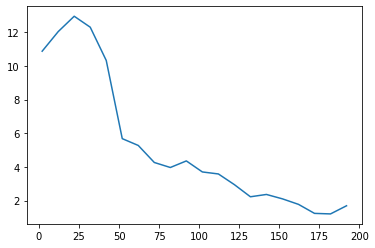

In [17]:
import seaborn as sns
sns.lineplot(x,y)
plt.show()

Makes sense, our data looks like 2 clusters, so highest DU for K=2 is what we expect. (the higher DU the better)!